# EDA AND PREPROCESSING
## Data Loading

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import os 
import sys
import time
import seaborn as sns
import math
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9004658356398268717,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9894756352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8580746684290485925
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [3]:
path = r'C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI_JS\TASK1-Fault_Detection\Data'

file_list = os.listdir(path)[2:]
assert len(file_list) == 10
print(file_list)

['train_1st_Bearing.csv', 'train_1st_high.csv', 'train_1st_Looseness.csv', 'train_1st_Normal.csv', 'train_1st_Unbalance.csv', 'train_2nd_Bearing.csv', 'train_2nd_Looseness.csv', 'train_2nd_Unbalance.csv', 'train_3rd_Normal.csv', 'train_3rd_Unbalance.csv']


In [4]:
#Normal[label 0] → Fault-free operating condition
#Unbalance[label 1] → Unbalance between centers of mass and axis
#Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
#Belt-Looseness High[label 3] → High Looseness of V-belt
#Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out

train_1st_Bearing = pd.read_csv(os.path.join(path, file_list[0]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Looseness = pd.read_csv(os.path.join(path, file_list[1]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Normal = pd.read_csv(os.path.join(path, file_list[2]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Unbalance = pd.read_csv(os.path.join(path, file_list[3]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_high = pd.read_csv(os.path.join(path, file_list[4]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Bearing = pd.read_csv(os.path.join(path, file_list[5]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Looseness = pd.read_csv(os.path.join(path, file_list[6]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Unbalance = pd.read_csv(os.path.join(path, file_list[7]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Normal = pd.read_csv(os.path.join(path, file_list[8]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Unbalance = pd.read_csv(os.path.join(path, file_list[9]),float_precision = 'round_trip').iloc[:, 1:]

In [5]:
print(
    train_1st_Normal.shape,
    train_1st_Bearing.shape,
    train_1st_Looseness.shape,
    train_1st_Unbalance.shape,
    train_1st_high.shape,
    train_2nd_Bearing.shape,
    train_2nd_Looseness.shape,
    train_2nd_Unbalance.shape,
    train_3rd_Normal.shape,
    train_3rd_Unbalance.shape
)

(6421296, 2) (18979200, 2) (4384196, 2) (15657840, 2) (11779756, 2) (41020378, 2) (32365862, 2) (30082032, 2) (52907684, 2) (23616452, 2)


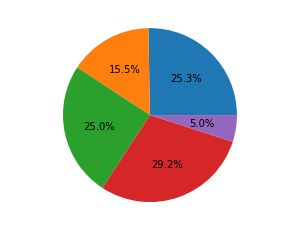

In [6]:
bearing = train_1st_Bearing.shape[0]+train_2nd_Bearing.shape[0]
looseness = train_1st_Looseness.shape[0]+train_2nd_Looseness.shape[0]
normal = train_1st_Normal.shape[0] + train_3rd_Normal.shape[0]
unbalance = train_1st_Unbalance.shape[0] + train_2nd_Unbalance.shape[0] + train_3rd_Unbalance.shape[0]
high = train_1st_high.shape[0] 

_, texts, _ = plt.pie([bearing, looseness, normal, unbalance, high], labels=['bearing', 'looseness', 'normal', 'unbalance', 'high'], autopct='%.1f%%')

for items in texts:
    items.set_color('white') 
    items.set_fontsize('14')

plt.show()

In [7]:
def Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):

  #Normal[label 0] → Fault-free operating condition
  #Unbalance[label 1] → Unbalance between centers of mass and axis
  #Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
  #Belt-Looseness High[label 3] → High Looseness of V-belt
  #Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out
  #int(np.ceil((df.shape[0] - time_series_length * 2) / window + 2))
  Number_of_samples = int(df.shape[0] / window) - 30
  data_array = np.zeros((Number_of_samples, time_series_length, NumofChannel)) # Defines input shape 
  label = np.full_like(np.zeros((Number_of_samples)), label) # label을 포함한 배열로 만들어줌 
  for i in tqdm(range(Number_of_samples)):
    data_array[i]= df.iloc[window * i : window * i + time_series_length,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array, label))
  return ds

def TEST_Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):
  Number_of_samples = int(df.shape[0] / window)
  data_array = np.zeros((Number_of_samples, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_samples)), label)
  for i in range(Number_of_samples):
    data_array[i]= df.iloc[window * i : window * i + time_series_length,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array, label))
  return ds 

In [9]:
sub = pd.read_csv(r'C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI_JS\TASK1-Fault_Detection\Data\sub\sample_submission_classification - 복사본.csv')
final = pd.read_csv(r'C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI_JS\TASK1-Fault_Detection\Data\sub\final.csv').iloc[:,1:]
test_Dataset = TEST_Dataset_Constructor(final).batch(256).prefetch(1)

## Dataset Construction/Augmentation and Solving Class Imbalance Problem

In [10]:
Bearing1st_ds = Dataset_Constructor(train_1st_Bearing, label = 4)
Looseness1st_ds = Dataset_Constructor(train_1st_Looseness,label = 2,window = 90)
Normal1st_ds = Dataset_Constructor(train_1st_Normal, label = 0 )
Unbalance1st_ds = Dataset_Constructor(train_1st_Unbalance, label = 1)
High1st_ds = Dataset_Constructor(train_1st_high, label = 3, window = 30)
Bearing2nd_ds = Dataset_Constructor(train_2nd_Bearing, label = 4)
Looseness2nd_ds = Dataset_Constructor(train_2nd_Looseness,label = 2,window = 90)
Unbalance2nd_ds = Dataset_Constructor(train_2nd_Unbalance, label = 1)
Normal3rd_ds = Dataset_Constructor(train_3rd_Normal, label = 0)
Unbalance3rd_ds = Dataset_Constructor(train_3rd_Unbalance, label = 1)

100%|██████████| 184473/184473 [00:05<00:00, 33502.49it/s]


463447 468686 408273 541754 392628


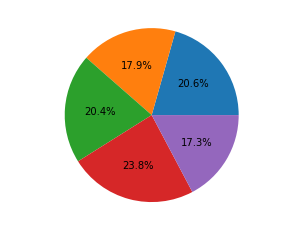

In [11]:
bearing = Bearing1st_ds.__len__().numpy() + Bearing2nd_ds.__len__().numpy()
looseness = Looseness1st_ds.__len__().numpy() + Looseness2nd_ds.__len__().numpy()
normal = Normal1st_ds.__len__().numpy() + Normal3rd_ds.__len__().numpy()
unbalance = Unbalance1st_ds.__len__().numpy() + Unbalance2nd_ds.__len__().numpy() + Unbalance3rd_ds.__len__().numpy()
high = High1st_ds.__len__().numpy()

_, texts, _ = plt.pie([bearing, looseness, normal, unbalance, high], labels=['bearing', 'looseness', 'normal', 'unbalance', 'high'], autopct='%.1f%%')

for items in texts:
    items.set_color('white') 
    items.set_fontsize('14')
print(normal, bearing, looseness, unbalance, high)
plt.show()

In [12]:
Dataset = (
    Bearing1st_ds.concatenate(Looseness1st_ds)
                        .concatenate(Normal1st_ds)
                        .concatenate(Unbalance1st_ds)
                        .concatenate(High1st_ds)
                        .concatenate(Bearing2nd_ds)
                        .concatenate(Looseness2nd_ds)
                        .concatenate(Unbalance2nd_ds)
                        .concatenate(Normal3rd_ds)
                        .concatenate(Unbalance3rd_ds)
                        .shuffle(buffer_size = 4518720, seed = 42)
                        .batch(256)
                        .prefetch(1)
)

# Most dataset input pipelines should end with a call to prefetch. 
# This allows later elements to be prepared while the current element is being processed. 
# This often improves latency and throughput, at the cost of using additional memory to store prefetched elements. 

In [13]:
Dataset.__len__().numpy()

8886

In [14]:
Dataset.cardinality

<bound method DatasetV2.cardinality of <PrefetchDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.float64)>>

In [15]:
Valid_Dataset = Dataset.take(1500) # Creates a Dataset with at most count elements from this dataset.
Train_Dataset = Dataset.skip(1500) # Creates a Dataset that skips count elements from this dataset.

In [16]:
print(Train_Dataset.cardinality)
print(Valid_Dataset.cardinality)
print(test_Dataset.cardinality)

<bound method DatasetV2.cardinality of <SkipDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.float64)>>
<bound method DatasetV2.cardinality of <TakeDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.float64)>>
<bound method DatasetV2.cardinality of <PrefetchDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.float64)>>


# VISUALIZATION

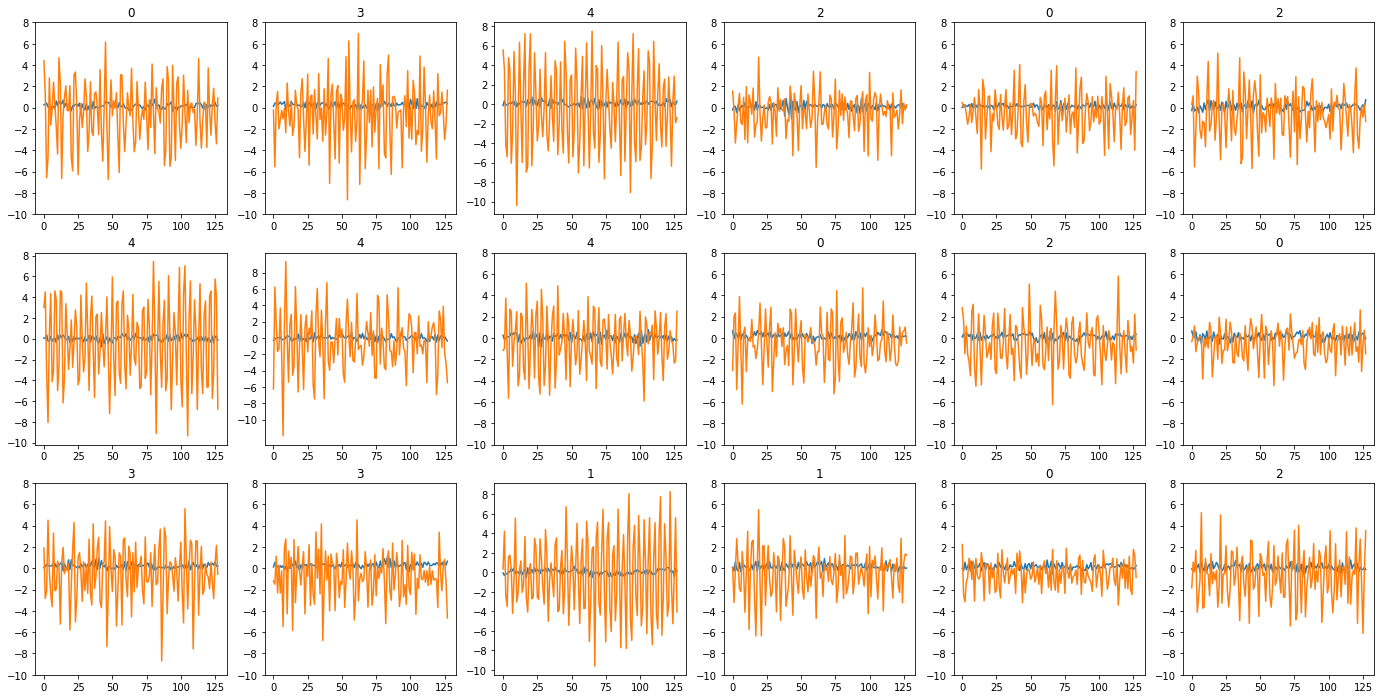

In [17]:
rows = 3
cols = 6
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
for i, (audio, label) in enumerate(Dataset.unbatch().take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-10, 10, 2))
  label = int(label.numpy())#.decode('utf-8')
  ax.set_title(label)

# Fast Fourier Transform and Continuous Wavelet Transform

In [18]:
Sample = list(Train_Dataset.unbatch().take(3000).as_numpy_iterator())[0][0]

## https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html

## https://pywavelets.readthedocs.io/en/latest/ref/cwt.html

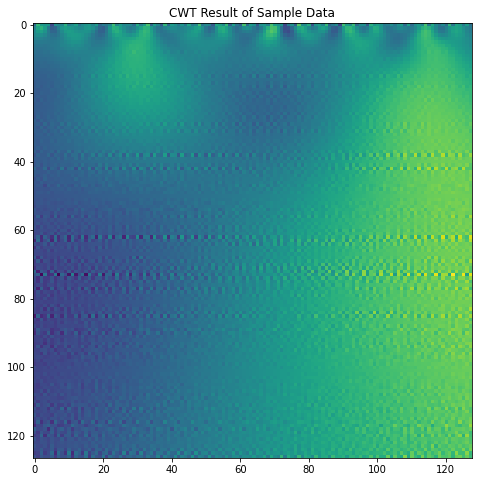

In [19]:
import pywt
from scipy import fftpack
# fft : 신호 데이터셋에서 시간 정보를 없애므로 정보 손실 발생하는 단점이 존재함.
# wavelet transform - wavelet을 filter로서 사용

coef, freqs = pywt.cwt(Sample ,np.arange(1,128), 'gaus1' , axis = 0)

fig = plt.figure()
fig.set_size_inches(8, 8)
plt.title("CWT Result of Sample Data")
plt.imshow(coef[:,:,0])

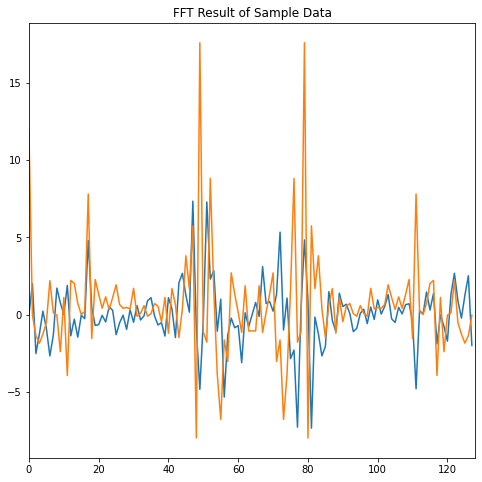

In [20]:
imag = fftpack.fft(Sample[:,0]).imag
real = fftpack.fft(Sample[:,0]).real
plt.figure().set_size_inches(8, 8)
plt.plot(imag)
plt.plot(real)
plt.xlim((0,128))
plt.title("FFT Result of Sample Data")
plt.show()

# CUSTOM MODELING

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    filepath = 'model.{epoch:02d}-{val_loss:.2f}.h5',
    monitor='sparse_categorical_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    save_freq = 'epoch'
)
earlystop = EarlyStopping(
    monitor='sparse_categorical_accuracy',
    min_delta=0.003,  # minimum value to determine 'improved'
    patience=2,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
)

reduce = ReduceLROnPlateau(
    monitor='sparse_categorical_accuracy',
    factor=0.5, 
    patience=2,
    min_delta = 0.003,  
    verbose=1, 
    mode='auto',
    cooldown = 5 
)

callbacks = [checkpoint, earlystop, tensorboard, reduce]

In [31]:
CUSTOM_MODEL = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(128, 2)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(units = 5, activation = 'softmax')
])

CUSTOM_MODEL.summary()
# 훈련 데이터의 label(target)이 정수일 경우 SparseCategoricalCrossentropy
# 이와 반대로 label이 one-hot vector일 경우 categoricalcrossentropy 사용
CUSTOM_MODEL.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(),                                                                              
        metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)              

In [32]:
%%time
history = CUSTOM_MODEL.fit(
    Train_Dataset,
    epochs = 10, 
    validation_data = Valid_Dataset,
    verbose = 1,
    callbacks = callbacks
)

Epoch 1/10
7386/7386 [==============================] - 38s 4ms/step - loss: 0.2694 - sparse_categorical_accuracy: 0.8903 - val_loss: 0.0362 - val_sparse_categorical_accuracy: 0.9882

Epoch 00001: sparse_categorical_accuracy improved from -inf to 0.89029, saving model to model.01-0.04.h5
Epoch 2/10
7386/7386 [==============================] - 36s 4ms/step - loss: 0.0614 - sparse_categorical_accuracy: 0.9786 - val_loss: 0.0210 - val_sparse_categorical_accuracy: 0.9931

Epoch 00002: sparse_categorical_accuracy improved from 0.89029 to 0.97864, saving model to model.02-0.02.h5
Epoch 3/10
7386/7386 [==============================] - 34s 4ms/step - loss: 0.0452 - sparse_categorical_accuracy: 0.9845 - val_loss: 0.0150 - val_sparse_categorical_accuracy: 0.9951

Epoch 00003: sparse_categorical_accuracy improved from 0.97864 to 0.98454, saving model to model.03-0.02.h5
Epoch 4/10
7386/7386 [==============================] - 35s 4ms/step - loss: 0.0375 - sparse_categorical_accuracy: 0.9873 - val

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

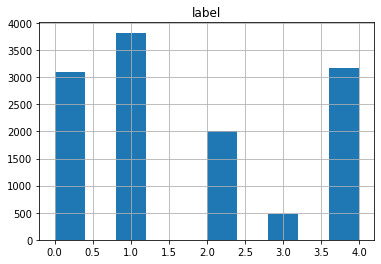

In [33]:
pred = CUSTOM_MODEL.predict(test_Dataset)
a = np.argmax(pred, axis=1)
sub.iloc[:,1] = a
sub.to_csv(r'C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI_JS\TASK1-Fault_Detection\CUSTOM_MODEL.csv', index = False)
sub.hist()

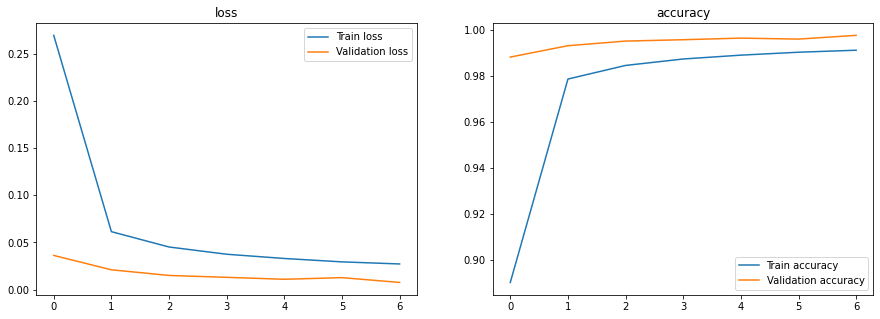

In [35]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["sparse_categorical_accuracy"], label="Train accuracy")
    ax[1].plot(history.epoch, history.history["val_sparse_categorical_accuracy"], label="Validation accuracy")
    ax[0].legend()
    ax[1].legend()
show_final_history(history)

In [ ]:
%load_ext tensorboard